In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
#from tensorflow.examples.tutorials.mnist import input_data
import pickle
from TFHelpers import *

from pylab import rcParams
rcParams['figure.figsize'] = 7, 7

/Users/artoni/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/artoni/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/artoni/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/artoni/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework

In [2]:
batch_size = 128
test_size = 256
img_shape = (32,32)
truelabels= ("S", "T")

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden):
    l1a = tf.nn.relu(tf.nn.conv2d(X, w,                       # l1a shape=(?, 32, 32, 32)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1],              # l1 shape=(?, 16, 16, 32)
                        strides=[1, 2, 2, 1], padding='SAME')
    l1 = tf.nn.dropout(l1, p_keep_conv)

    l2a = tf.nn.relu(tf.nn.conv2d(l1, w2,                     # l2a shape=(?, 16, 16, 64)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1],              # l2 shape=(?, 8, 8, 64)
                        strides=[1, 2, 2, 1], padding='SAME')
    l2 = tf.nn.dropout(l2, p_keep_conv)

    l3a = tf.nn.relu(tf.nn.conv2d(l2, w3,                     # l3a shape=(?, 8, 8, 128)
                        strides=[1, 1, 1, 1], padding='SAME'))
    l3b = tf.nn.max_pool(l3a, ksize=[1, 2, 2, 1],              # l3 shape=(?, 4, 4, 128)
                        strides=[1, 2, 2, 1], padding='SAME')
    l3b = tf.nn.dropout(l3b, p_keep_conv)
    l3 = tf.reshape(l3b, [-1, w4.get_shape().as_list()[0]])    # reshape to (?, 2048)

    l4 = tf.nn.relu(tf.matmul(l3, w4))
    l4 = tf.nn.dropout(l4, p_keep_hidden)

    pyx = tf.matmul(l4, w_o)
    return pyx, l1, l2, l3b, l3

trX=pickle.load( open( "images.p", "rb" ) )
trY=np.asarray(pickle.load( open( "labels.p", "rb" ) ))
teX=pickle.load( open( "imagesTest.p","rb"))
teY=np.asarray(pickle.load(open("labelsTest.p","rb")))
trX = np.asarray(trX).reshape(-1,32,32,1) #32x32,1 input image
teX = np.asarray(teX).reshape(-1,32,32,1) #32x32,1 input image

#mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
#trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
#trX = trX.reshape(-1, 28, 28, 1)  # 28x28x1 input img
#teX = teX.reshape(-1, 28, 28, 1)  # 28x28x1 input img

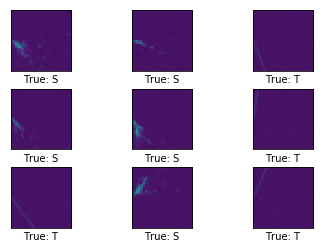

In [3]:
plot_images(trX[0:9],trY[0:9])

In [4]:
#Make place holder variables for dataset and labels
X = tf.placeholder("float", [None, 32, 32, 1])
Y = tf.placeholder("float", [None, 2])

#Make place holder variables for each weight tensor with appropriate dimensions
w = init_weights([3, 3, 1, 32])       # 3x3x1 conv, 32 outputs
w2 = init_weights([3, 3, 32, 64])     # 3x3x32 conv, 64 outputs
w3 = init_weights([3, 3, 64, 128])    # 3x3x32 conv, 128 outputs
w4 = init_weights([128 * 4 * 4, 625]) # FC 128 * 4 * 4 inputs, 625 outputs
w_o = init_weights([625, 2])         # FC 625 inputs, 2 outputs (labels)

#Make placeholders for parameters specifying dropout rates (to be used during training)
p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")
py_x, l1, l2, l3b, l3 = model(X, w, w2, w3, w4, w_o, p_keep_conv, p_keep_hidden)

#Cost function is mean of softmax cross entropy (see https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=Y))
#Define training operation (minimize cost function)
#See https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer
train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
#Define prediction operation
predict_op = tf.argmax(py_x, 1)

In [5]:
def plot_example_errors(testimages, testclasses,cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    #incorrect = (correct == False)
    #get indices of incorrect predictions
    incorrect = np.where(correct==False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = testimages[incorrect]

    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = testclasses[incorrect]
    
    # Plot the first 9 images.
    #if len(images)>=9:
    plot_images(images=images[0:9],
            cls_true=cls_true[0:9],
            cls_pred=cls_pred[0:9])

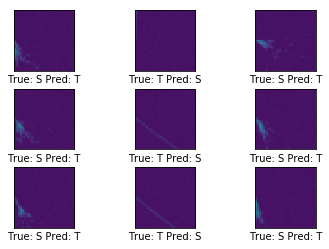

Batch 0, Accuracy 0.679688


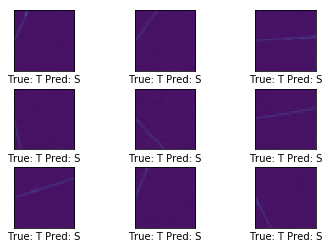

Batch 1, Accuracy 0.507812


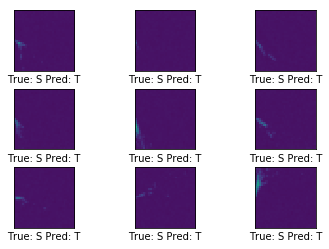

Batch 2, Accuracy 0.765625


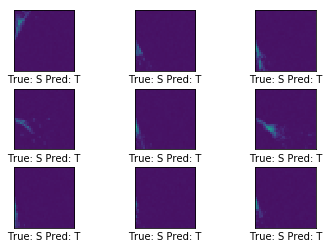

Batch 3, Accuracy 0.781250


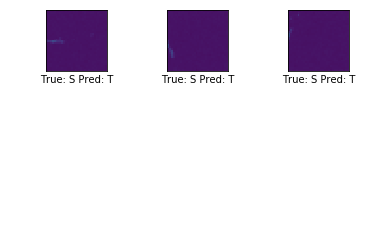

Batch 4, Accuracy 0.988281


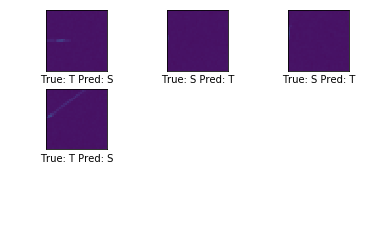

Batch 5, Accuracy 0.984375


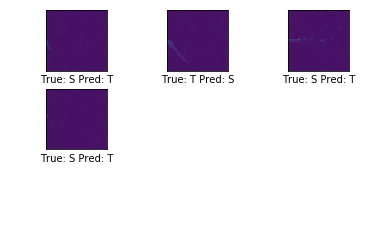

Batch 6, Accuracy 0.984375


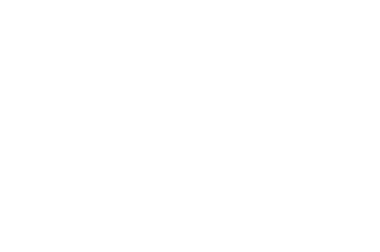

Batch 7, Accuracy 1.000000


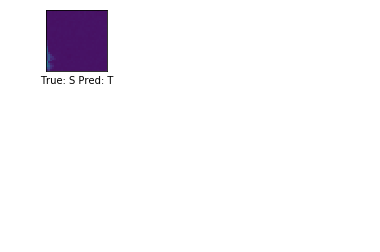

Batch 8, Accuracy 0.996094


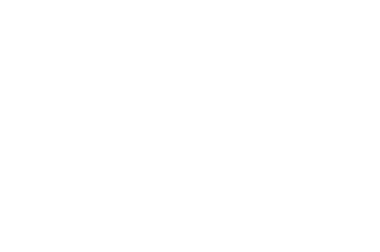

Batch 9, Accuracy 1.000000


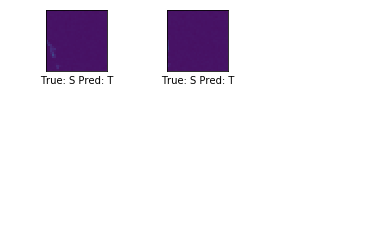

Batch 10, Accuracy 0.992188


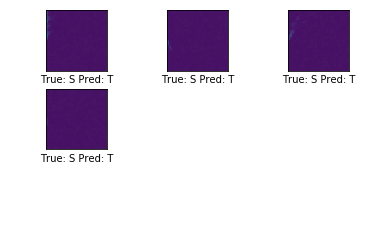

Batch 11, Accuracy 0.984375


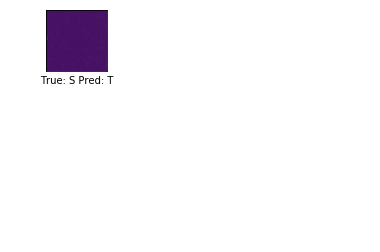

Batch 12, Accuracy 0.996094


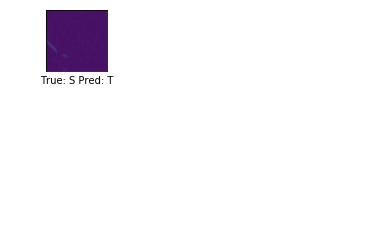

Batch 13, Accuracy 0.996094


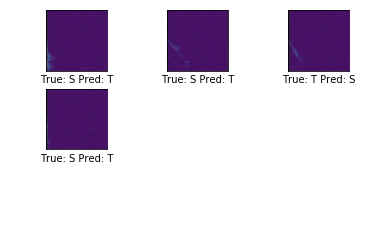

Batch 14, Accuracy 0.984375


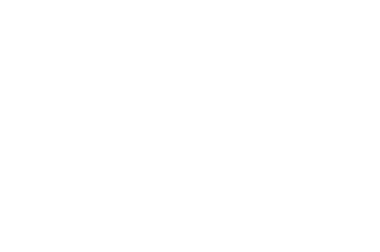

Batch 15, Accuracy 1.000000


In [6]:
# Launch the graph in a session
sess=tf.Session()
#with tf.Session() as sess:
# you need to initialize all variables
sess.run(tf.global_variables_initializer())

for i in range(16):
    training_batch = zip(range(0, len(trX), batch_size),
                         range(batch_size, len(trX)+1, batch_size))
    for start, end in training_batch:
        #Note: 0.8*0.8*0.8 ~= 0.5 (dropout for each conv layer)
        sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end],
                                      p_keep_conv: 0.8, p_keep_hidden: 0.5})
        

    test_indices = np.arange(len(teX)) # Get A Test Batch
    np.random.shuffle(test_indices)
    test_indices = test_indices[0:test_size]

    test_pred=sess.run(predict_op, feed_dict={X: teX[test_indices],
                                                     Y: teY[test_indices],
                                                     p_keep_conv: 1.0,
                                                     p_keep_hidden: 1.0})
    #print(np.argmax(teY[test_indices], axis=1) == test_pred)
    plot_example_errors(teX[test_indices],teY[test_indices],test_pred, np.argmax(teY[test_indices], axis=1) == test_pred)
    print("Batch %d, Accuracy %f" %(i, np.mean(np.argmax(teY[test_indices], axis=1) == test_pred)))
        

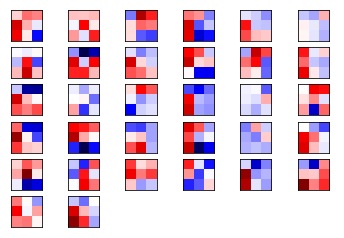

In [7]:
plot_conv_weights(sess.run(w))

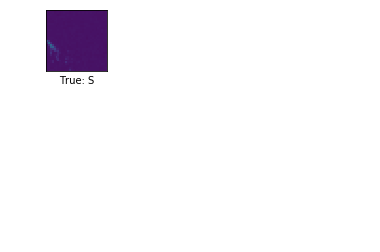

In [8]:
#Plot image to be tracked through network    
plot_images(trX[3:4],trY[3:4])

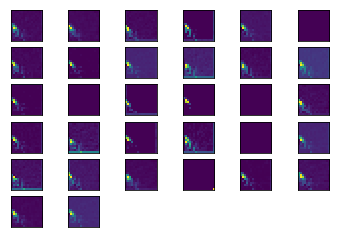

In [9]:
plot_conv_layer(sess, l1, trX[3], trY[3], X, Y,p_keep_conv,p_keep_hidden)

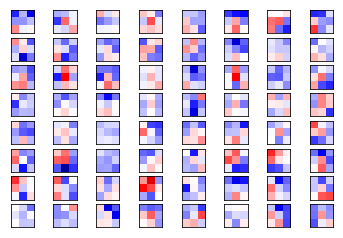

In [10]:
plot_conv_weights(sess.run(w2))

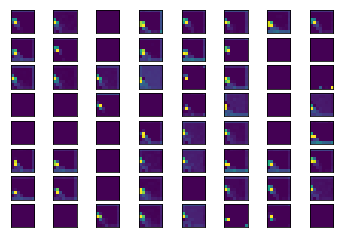

In [11]:
plot_conv_layer(sess, l2, trX[3], trY[3], X, Y,p_keep_conv,p_keep_hidden)

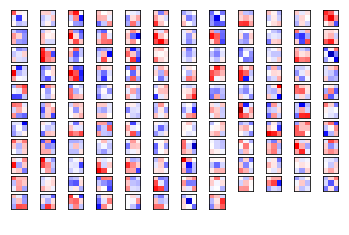

In [12]:
plot_conv_weights(sess.run(w3))

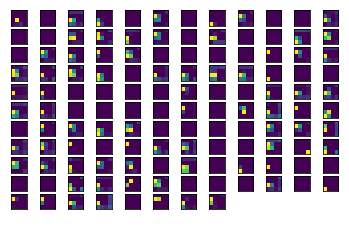

In [13]:
plot_conv_layer(sess, l3b, trX[3], trY[3], X, Y,p_keep_conv,p_keep_hidden)